# Notebook for creating figures of placement of weather stations in Ontario

[Provincial boundary data](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-eng.cfm?year=21)

[Canadian Population](https://open.canada.ca/data/en/dataset/c6c48391-fd2f-4d8a-93c8-eb74f58a859b)

In [102]:
import geopandas as gp
import geodatasets
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
import os

Read in population, boundary, and weather station shape files and coordinates

In [104]:
#import shapefile of the population of Canada by 10 km grids
df_pop = gp.read_file("data" + os.sep + "griddedPopulationCanada10km_2016_shp/griddedPopulationCanada10km_2016.shp")
#import provincial boundary shapefile
df_bound = gp.read_file("data" + os.sep + "lpr_000b16a_e/lpr_000b16a_e.shp")

In [106]:
#change the projection to be 3857 or 4326
df_pop = df_pop.to_crs(epsg=3857)
df_bound = df_bound.to_crs(epsg=3857)

In [107]:
#take log of populaiton to better visualize large population discrepandies
df_pop['TOT_NIPOP2_log'] = np.log(df_pop['TOT_NIPOP2']+1)

In [ ]:
#Identify boundary of provences to zoom in on map
df_bound.bounds.head(5)

Read in weather station locations and fire weather index

In [ ]:
#fwi for all weather stations in Canada, calculated by the Canadian Government
df_initial = pd.read_csv("data" + os.sep + "Initial_State.csv", index_col = 0)
#convert into geopandas dataframe
fwi_initial = gp.GeoDataFrame(df_initial, geometry=gp.points_from_xy(df_initial.x, df_initial.y), crs = "EPSG:4326")
fwi_initial.to_crs(epsg=3857).head(5)

Read in predicitons for Ontario weather stations based on Temperature (t), Humidity (h), Precipitation (p), and wind speed (s)

In [111]:
#fwi prediction
df_pred = pd.read_csv("data" + os.sep + "ontario_stations_mean_fwi_and_predictions.csv", index_col = 0)

In [113]:
#compute the accuracy of the models with the percent error   
df_pred['thps_accuracy']=(df_pred['fwi']-df_pred['thps_predictions']).abs()/df_pred['fwi']
df_pred['hps_accuracy']=(df_pred['fwi']-df_pred['hps_predictions']).abs()/df_pred['fwi']
df_pred['tps_accuracy']=(df_pred['fwi']-df_pred['tps_predictions']).abs()/df_pred['fwi']
df_pred['ths_accuracy']=(df_pred['fwi']-df_pred['ths_predictions']).abs()/df_pred['fwi']
df_pred['thp_accuracy']=(df_pred['fwi']-df_pred['thp_predictions']).abs()/df_pred['fwi']
df_pred['ths_diff']=(df_pred['fwi']-df_pred['ths_predictions']).abs()

In [114]:
df_pred.describe()

,Unnamed: 0,x,y,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION,fwi,thps_predictions,hps_predictions,tps_predictions,ths_predictions,thp_predictions,thps_accuracy,hps_accuracy,tps_accuracy,ths_accuracy,thp_accuracy,ths_diff
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,80772.107143,-82.575222,46.746618,5.542294,91.381698,36.534758,2.484446,5.210508,5.179008,5.157342,5.349040,5.032471,4.859821,0.006353,0.026041,0.057838,0.092620,0.229153,0.493339
std,50133.311971,4.791510,3.521629,3.422057,2.069296,7.429203,0.597929,1.589153,1.584394,1.628140,1.641062,1.310573,0.661624,0.001391,0.021111,0.045837,0.067634,0.154958,0.435353
min,359.000000,-94.377778,42.033333,-3.221506,86.161686,17.989429,0.689192,1.980104,1.953699,1.861442,2.211509,2.185449,3.382731,0.003727,0.000312,0.001121,0.003983,0.004357,0.026610
25%,37599.000000,-85.735833,43.929583,3.574436,90.112122,30.988228,2.206324,3.977581,3.946359,3.928648,4.087780,4.116290,4.495440,0.005530,0.010067,0.024852,0.042422,0.122487,0.180143
50%,78293.500000,-81.242639,45.632500,6.185637,91.198931,38.548431,2.508157,5.030779,5.001626,4.999620,5.229942,4.682309,4.816706,0.006231,0.019399,0.051143,0.081319,0.192427,0.346365
75%,125590.250000,-79.407859,49.410347,8.028832,92.637352,42.681366,2.771755,6.544539,6.515070,6.597471,6.809958,5.964360,5.278768,0.007169,0.040104,0.071166,0.139828,0.279103,0.739295
max,169873.500000,-74.962778,56.018889,13.430252,96.079523,47.000772,4.323643,9.792895,9.756397,9.772682,9.930353,8.721559,6.553540,0.013335,0.108191,0.222187,0.263892,0.766097,1.917985


In [115]:
#convert into geopandas dataframe
fwi_mean = gp.GeoDataFrame(df_pred, geometry=gp.points_from_xy(df_pred.x, df_pred.y), crs = "EPSG:4326")
fwi_wm = fwi_mean.to_crs(epsg=3857)

Map population to the location of weather stations used to predict FWI

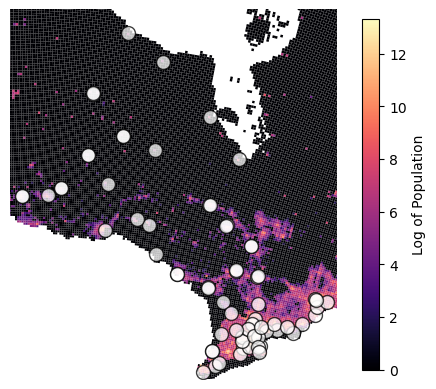

In [116]:
ax = df_pop.plot(column = "TOT_NIPOP2_log", legend = True, cmap = 'magma', #vmin = 0, vmax=1,
                 legend_kwds={"shrink":.95, "label": "Log of Population"})
df_bound.plot(ax = ax, alpha = 0, edgecolor='black')
fwi_wm.plot(ax = ax,markersize = 100,color = 'white', alpha = 0.75, edgecolor = 'black')

#set axis limits to only include Ontario
ax.set_xlim(-1.059259*10**7, -8.275880*10**6)
ax.set_ylim(5.113378*10**6, 7.731361*10**6)

ax.set_axis_off();
plt.savefig('figures' + os.sep + 'pop_and_stations.png')

In [118]:
fwi_mean.describe()

,Unnamed: 0,x,y,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION,fwi,thps_predictions,hps_predictions,tps_predictions,ths_predictions,thp_predictions,thps_accuracy,hps_accuracy,tps_accuracy,ths_accuracy,thp_accuracy,ths_diff
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,80772.107143,-82.575222,46.746618,5.542294,91.381698,36.534758,2.484446,5.210508,5.179008,5.157342,5.349040,5.032471,4.859821,0.006353,0.026041,0.057838,0.092620,0.229153,0.493339
std,50133.311971,4.791510,3.521629,3.422057,2.069296,7.429203,0.597929,1.589153,1.584394,1.628140,1.641062,1.310573,0.661624,0.001391,0.021111,0.045837,0.067634,0.154958,0.435353
min,359.000000,-94.377778,42.033333,-3.221506,86.161686,17.989429,0.689192,1.980104,1.953699,1.861442,2.211509,2.185449,3.382731,0.003727,0.000312,0.001121,0.003983,0.004357,0.026610
25%,37599.000000,-85.735833,43.929583,3.574436,90.112122,30.988228,2.206324,3.977581,3.946359,3.928648,4.087780,4.116290,4.495440,0.005530,0.010067,0.024852,0.042422,0.122487,0.180143
50%,78293.500000,-81.242639,45.632500,6.185637,91.198931,38.548431,2.508157,5.030779,5.001626,4.999620,5.229942,4.682309,4.816706,0.006231,0.019399,0.051143,0.081319,0.192427,0.346365
75%,125590.250000,-79.407859,49.410347,8.028832,92.637352,42.681366,2.771755,6.544539,6.515070,6.597471,6.809958,5.964360,5.278768,0.007169,0.040104,0.071166,0.139828,0.279103,0.739295
max,169873.500000,-74.962778,56.018889,13.430252,96.079523,47.000772,4.323643,9.792895,9.756397,9.772682,9.930353,8.721559,6.553540,0.013335,0.108191,0.222187,0.263892,0.766097,1.917985


Map the fire station FWI, the predicted FWI, and the percent error

FWI values

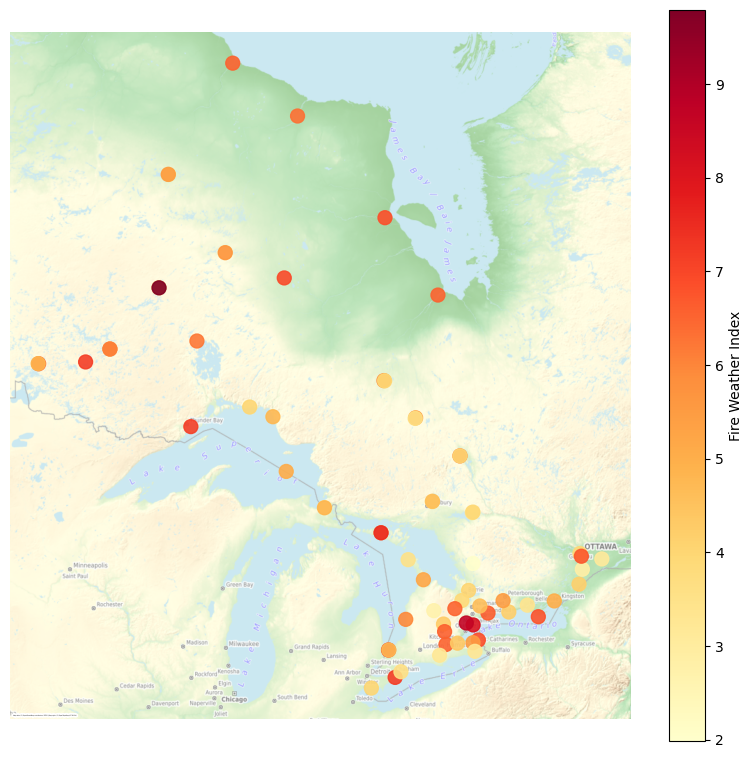

In [121]:
ax = fwi_wm.plot(figsize=(10, 10), alpha=0.9, column = 'fwi', markersize = 100, cmap = 'YlOrRd', legend = True,
                 legend_kwds={"shrink":.95, "label": "Fire Weather Index"})
cx.add_basemap(ax, source=cx.providers.OpenTopoMap, crs=fwi_wm.crs, alpha = 0.5, attribution_size=0)
ax.set_axis_off();
plt.savefig('figures' + os.sep + 'fwi.png')

Predictions from Tempterature (t), Humidity (h), and Wind speed (s)

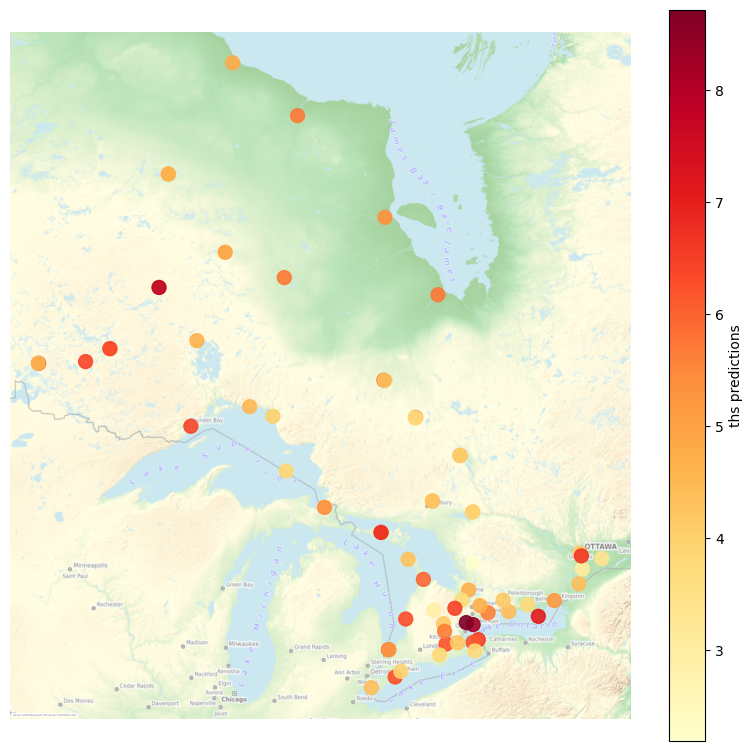

In [122]:
ax = fwi_wm.plot(figsize=(10, 10), alpha=0.9, column = 'ths_predictions', markersize = 100, cmap = 'YlOrRd', legend = True,
                 legend_kwds={"shrink":.95, "label": "ths predictions"})
cx.add_basemap(ax, source=cx.providers.OpenTopoMap, crs=fwi_wm.crs, alpha = 0.5, attribution_size=0)
ax.set_axis_off();
plt.savefig('figures' + os.sep + 'ths_predictions.png')

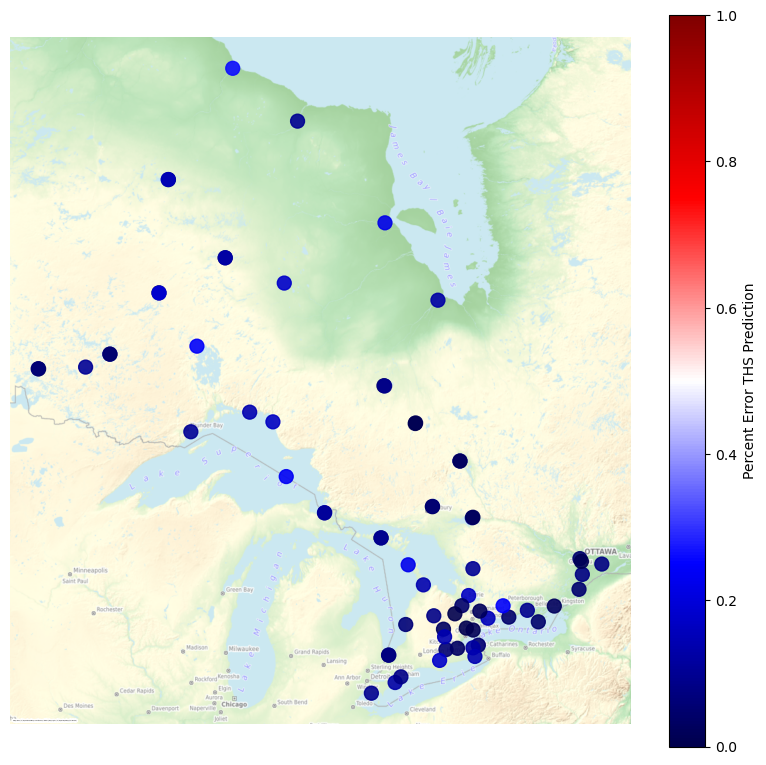

In [123]:
ax = fwi_wm.plot(figsize=(10, 10), alpha=0.9, column = 'ths_accuracy', markersize = 100, cmap = 'seismic', legend = True, vmin = 0, vmax=1,
                 legend_kwds={"shrink":.95, "label": "Percent Error THS Prediction"})
cx.add_basemap(ax, source=cx.providers.OpenTopoMap, crs=fwi_wm.crs, alpha = 0.5, attribution_size=0)
ax.set_axis_off();
plt.savefig('figures' + os.sep +'ths_accuracy.png')